# Team Project #4 - Spatial Estimation
## Dr. Pyrcz's Stochastic Method for Reservoir Modeling
## Team 4: Qiqi Wang, Jiacheng Wang, Yanli pei, Honggeun Jo



## Objectives
### 1. Apply indicator kriging for facies to calculate the propability of each facies across the reservoir
               
### 2. Apply oridnary kriging for porosity and permeability to calculate the kriging estimate and variance (by-facies)

### 3. Build a combined model with porosity and permeability (cookie-cutter approach)

### 4. Report local P10 and P90 map for porosity and permeability at all locations (probability of each facies, CDF)

### 5. Pick 2 candidate well locations and provide a predrill porosity uncertainty distribution (linear family of distribution models)

# 0. Load package, initial setting, and fetching data

In [184]:
## Import needed package
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from scipy import stats                                     # summary stats
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        
import seaborn as sns
import scipy.stats as st                               # statistical methods
import scipy.signal as signal             # kernel for moving window calculation
import random
import math  

## Set Working Directory
os.chdir("C:/Users/hj6488/Box Sync/04_Course work (Spring 2019)/200-Stoch Method for Reservoir Modeling/217 Project 4")  # set the working directory

# Load Data 
df = pd.read_csv("4_sample_data.csv")                       # well sample data
#AI_map = np.loadtxt("4_AI.csv", delimiter = ",")            # AI map

#Log permeability 
df['lnPerm'] = np.log(df['Perm'])
df_sand = pd.DataFrame.copy(df[df['Facies'] == 1]).reset_index()  # copy only 'Facies' = sand records
df_shale = pd.DataFrame.copy(df[df['Facies'] == 0]).reset_index() # copy only 'Facies' = shale records

It seems that the first column seems not needed...

In [23]:
df.head()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI,lnPerm
0,5,70,580,1,0.102475,30.149009,3477.934210,3.406152
1,15,140,860,1,0.086987,8.540175,3500.807463,2.144782
2,22,140,370,1,0.091117,266.893061,3478.303116,5.586848
3,23,140,300,1,0.097404,5.483678,3428.434722,1.701776
4,24,140,230,1,0.089087,29.146330,3853.554854,3.372329


In [24]:
df.describe().transpose()                          # summary table of all facies combined DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,178.0,282.668539,156.940549,5.000000,167.500000,266.500000,426.500000,563.000000
X,178.0,470.393258,239.548451,0.000000,300.000000,480.000000,630.000000,980.000000
Y,178.0,636.977528,272.854465,9.000000,442.250000,719.500000,864.000000,999.000000
Facies,178.0,0.887640,0.316699,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,178.0,0.122491,0.035144,0.078601,0.091162,0.116853,0.151399,0.186311
Perm,178.0,162.372756,585.370901,0.027218,5.745164,23.820284,90.555638,5689.823420
AI,178.0,3115.424695,798.465526,1759.403262,2439.938679,2937.328223,3787.043657,5124.532354
lnPerm,178.0,3.067144,2.164116,-3.603864,1.747806,3.170535,4.505274,8.646434


In [25]:
df_sand.describe().transpose()                     # summary table of sand only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,158.0,87.278481,51.309958,0.000000,43.750000,85.500000,131.750000,177.000000
Unnamed: 0,158.0,278.949367,156.233404,5.000000,155.500000,261.500000,424.250000,563.000000
X,158.0,452.215190,222.892460,10.000000,292.500000,475.000000,602.500000,980.000000
Y,158.0,678.708861,235.287608,9.000000,526.500000,739.000000,867.750000,999.000000
Facies,158.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Porosity,158.0,0.126750,0.035001,0.079210,0.092165,0.122782,0.158212,0.186311
Perm,158.0,180.220811,619.080385,0.027218,7.482659,26.373074,106.854123,5689.823420
AI,158.0,2958.664034,693.430024,1759.403262,2383.633549,2860.908860,3478.210890,4516.534318
lnPerm,158.0,3.267258,2.119466,-3.603864,2.012541,3.272131,4.671464,8.646434


In [26]:
df_shale.describe().transpose()                    # summary table of shale only DataFrame statistics

,count,mean,std,min,25%,50%,75%,max
index,20.0,98.150000,53.572651,8.000000,44.750000,100.000000,143.250000,175.000000
Unnamed: 0,20.0,312.050000,163.501964,41.000000,174.500000,301.500000,460.250000,555.000000
X,20.0,614.000000,315.584670,0.000000,410.000000,710.000000,872.500000,950.000000
Y,20.0,307.300000,327.438881,20.000000,46.500000,194.500000,476.500000,979.000000
Facies,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Porosity,20.0,0.088845,0.006369,0.078601,0.083631,0.090610,0.093412,0.097991
Perm,20.0,21.373123,40.267366,0.212234,1.200728,2.866398,16.343926,130.115998
AI,20.0,4353.833915,383.703071,3771.938792,4139.550650,4256.907100,4659.196986,5124.532354
lnPerm,20.0,1.486249,1.883225,-1.550068,0.167469,1.051763,2.792188,4.868426


In [27]:
plt.subplot(121)                                        # plot original sand and shale porosity histograms
plt.hist(df['Porosity'], facecolor='red',bins=np.linspace(0.0,0.25,1000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25]); plt.ylim([0,1.0])
plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(122)                                        # plot original sand and shale permeability histograms
plt.hist(df['Perm'], facecolor='red',bins=np.linspace(0.0,1000.0,100000),histtype="stepfilled",alpha=0.2,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]); plt.ylim([0,1.0])
plt.xlabel('Permeability (mD)'); plt.ylabel('Frequency'); plt.title('Permeability')
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

AttributeError: Unknown property density

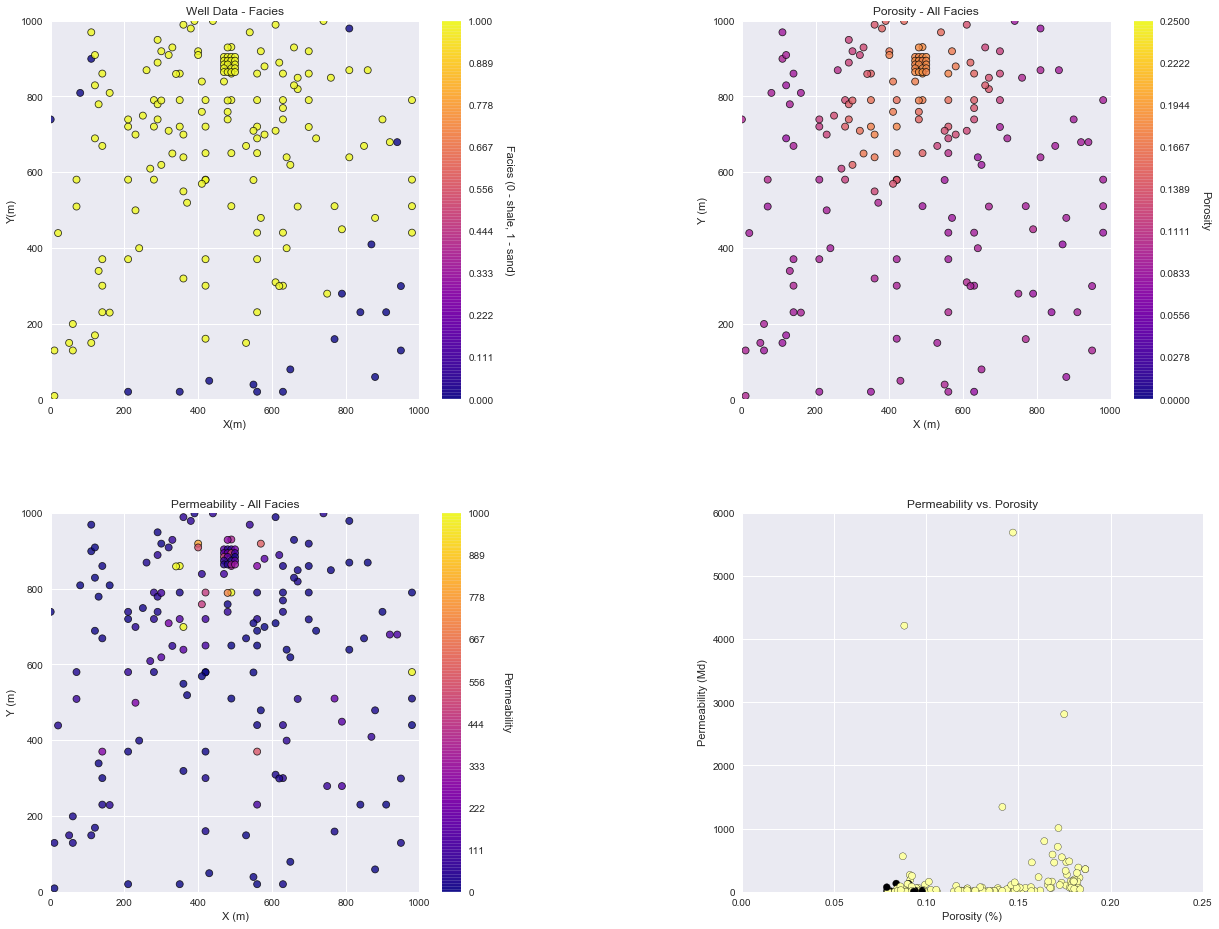

In [28]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values

xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

cmap = plt.cm.plasma                    # color map
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,0,1,'Well Data - Facies','X(m)','Y(m)','Facies (0 - shale, 1 - sand)',cmap)

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - All Facies','X (m)','Y (m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - All Facies','X (m)','Y (m)','Permeability',cmap)

plt.subplot(224)
facies = df['Facies'].values +0.01
plt.scatter(df['Porosity'],df['Perm'],c = facies,edgecolor = 'black',cmap = plt.cm.inferno)
#plt.plot([-3,3],[-3,3],color = 'black')
plt.xlabel(r'Porosity (%)')
plt.ylabel(r'Permeability (Md)')
plt.title('Permeability vs. Porosity')
plt.xlim([0,0.25])
plt.ylim([0,6000])
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)
plt.show()

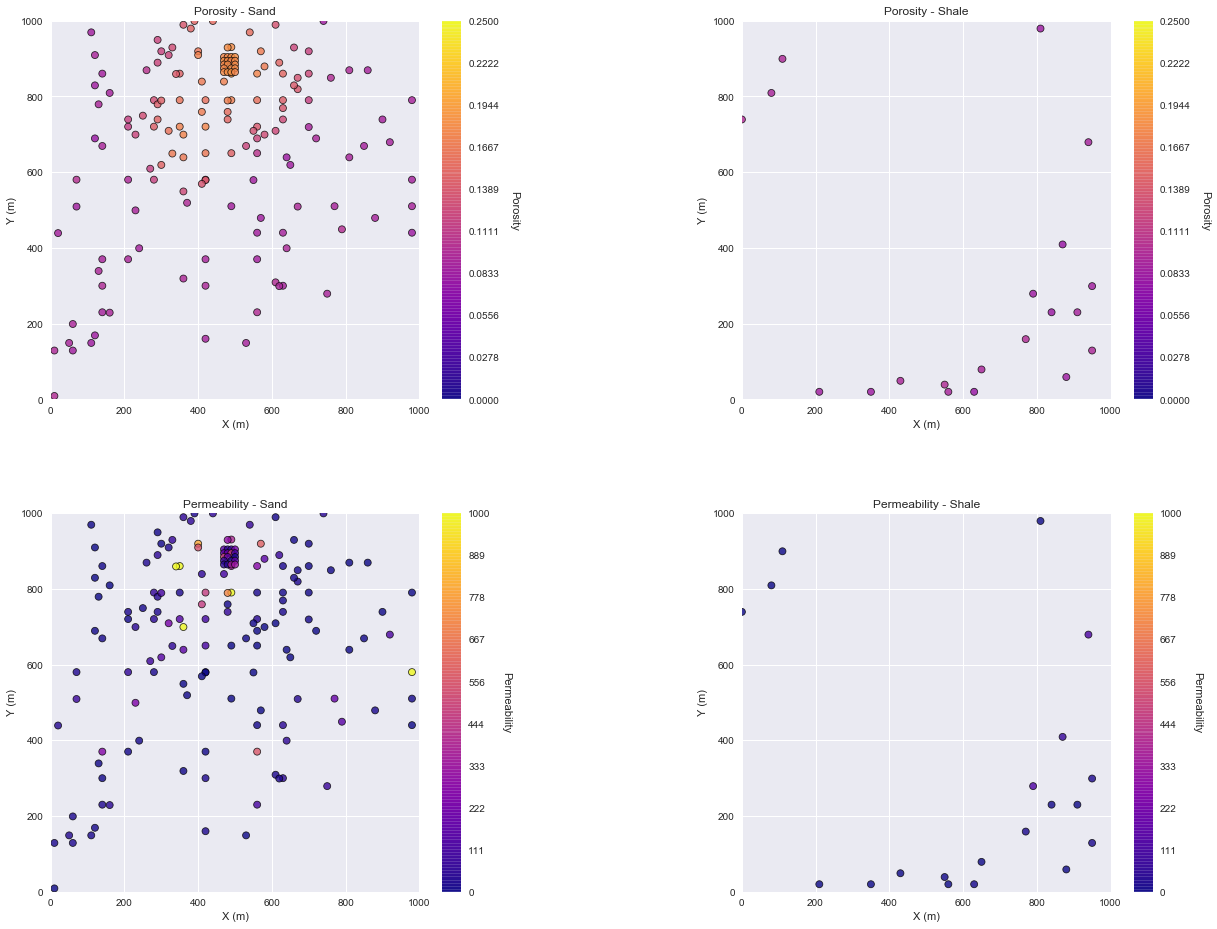

In [29]:
plt.subplot(221)
GSLIB.locmap_st(df_sand,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Sand','X (m)','Y (m)','Porosity',cmap)

plt.subplot(222)
GSLIB.locmap_st(df_shale,'X','Y','Porosity',0,1000,0,1000,0,0.25,'Porosity - Shale','X (m)','Y (m)','Porosity',cmap)

plt.subplot(223)
GSLIB.locmap_st(df_sand,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Sand','X (m)','Y (m)','Permeability',cmap)

plt.subplot(224)
GSLIB.locmap_st(df_shale,'X','Y','Perm',0,1000,0,1000,0,1000,'Permeability - Shale','X (m)','Y (m)','Permeability',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.5, hspace=0.3)
plt.show()

# 1. Indicator Kriging for Facies

In [30]:
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits

In [37]:
ncut = 2                                   # number of facies
thresh = [0,1]                             # the facies categories
gcdf = [1-0.887,0.887]                         # the global proportions of the categories (from update #2)
varios = []                                # the variogram list
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=3,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # shale indicator variogram
varios.append(GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=0.2,azi1=45,hmaj1=500,hmin1=200,it2=3,cc2=0.8,azi2=45,hmaj2=9999,hmin2=700)) # sand indicator variogram


Data for IK3D: Variable column Facies
  Number   = 178
Setting up rotation matrices for variogram and search
Working on the kriging
   currently on estimate 0
   currently on estimate 1000
   currently on estimate 2000
   currently on estimate 3000
   currently on estimate 4000
   currently on estimate 5000
   currently on estimate 6000
   currently on estimate 7000
   currently on estimate 8000
   currently on estimate 9000


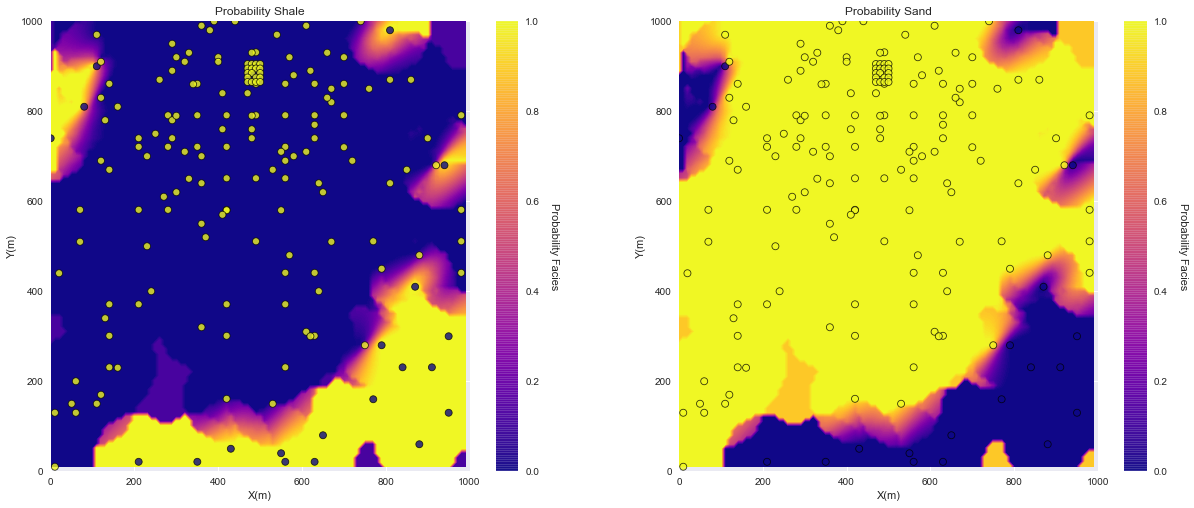

In [38]:
no_trend = np.zeros((1,1))                  # null ndarray not of correct size so ik2d will not use a trend - will fix this
ikmap = geostats.ik2d(df,'X','Y','Facies',ivtype,0,2,thresh,gcdf,no_trend,tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz, ndmin,ndmax,radius,ktype,vario=varios)

plt.subplot(221) 
GSLIB.locpix_st(ikmap[:,:,0],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Shale','X(m)','Y(m)','Probability Facies',cmap)
plt.subplot(222) 
GSLIB.locpix_st(ikmap[:,:,1],xmin,xmax,ymin,ymax,xsiz,0.0,1.0,df,'X','Y','Facies','Probability Sand','X(m)','Y(m)','Probability Facies',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2) 
plt.show()

# 2. Ordinary Kriging for Porosity and Permeability (by-facies)


In [110]:
# Decluster for mean poro and perm
wts_sand, cell_sizes_sand, dmeans_sand = geostats.declus(df_sand,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_sand, cell_sizes_sand, dmeans_sand = geostats.declus(df_sand,'X','Y','lnPerm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_shale, cell_sizes_shale, dmeans_shale = geostats.declus(df_shale,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
wts_shale, cell_sizes_shale, dmeans_shale = geostats.declus(df_shale,'X','Y','lnPerm',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
NULL, cell_sizes_shale, dmeans_shale = geostats.declus(df,'X','Y','Facies',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)

df_sand['Wts'] = wts_sand  
df_shale['Wts'] = wts_shale

There are 158 data with:
   mean of      0.12675028956329115 
   min and max  0.079210481 and 0.186311206
   standard dev 0.03488960752802084 
There are 158 data with:
   mean of      3.267257721971372 
   min and max  -3.6038637538296845 and 8.646434493246915
   standard dev 2.112748390701247 
There are 20 data with:
   mean of      0.088845095 
   min and max  0.078601287 and 0.097991102
   standard dev 0.006207447586087688 
There are 20 data with:
   mean of      1.486249483680157 
   min and max  -1.5500677147257595 and 4.868426341832965
   standard dev 1.835541132752634 
There are 178 data with:
   mean of      0.8876404494382022 
   min and max  0 and 1
   standard dev 0.31580829938326277 


In [112]:
skmean_por_sand = 0.13; skmean_por_shale = 0.09
skmean_perm_sand = 180.2; skmean_perm_shale = 21.4

skstd_por_sand = 0.034889; skstd_por_shale = 0.00620
skstd_lnperm_sand = 2.1127; skstd_lnperm_shale = 1.8355


ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 10                      # minimum and maximum data for an estimate
tmin = 0.0                                 # minimum property value

por_sand_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=22.5,hmaj1=200,hmin1=50,it2=3,cc2=0.8,azi2=22.5,hmaj2=600,hmin2=250) # porosity sand variogram
por_shale_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=22.5,hmaj1=100,hmin1=50,it2=3,cc2=0.8,azi2=22.5,hmaj2=900,hmin2=300) # porosity shale variogram

perm_sand_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.4,azi1=45,hmaj1=150,hmin1=100,it2=3,cc2=0.6,azi2=45,hmaj2=900,hmin2=180) # perm sand variogram
perm_shale_vario = GSLIB.make_variogram(nug=0.0,nst=2,it1=2,cc1=0.2,azi1=45,hmaj1=900,hmin1=100,it2=3,cc2=0.8,azi2=45,hmaj2=900,hmin2=180) # perm shale variogram

facies_kmap = np.zeros((ny,nx)); por_kmap = np.zeros((ny,nx)); perm_kmap = np.zeros((ny,nx)) # declare array to combine values

In [170]:
por_sand_kmap, por_sand_vmap = geostats.kb2d(df_sand,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_sand,por_sand_vario)
perm_sand_kmap, perm_sand_vmap = geostats.kb2d(df_sand,'X','Y','lnPerm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_lnperm_sand,perm_sand_vario)
por_shale_kmap, por_shale_vmap = geostats.kb2d(df_shale,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_por_shale,por_shale_vario)
perm_shale_kmap, perm_shale_vmap = geostats.kb2d(df_shale,'X','Y','lnPerm',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean_lnperm_shale,perm_shale_vario)


  Estimated   10000 blocks 
      average   0.110282669175  variance  0.000519238731164
  Estimated   10000 blocks 
      average   3.1874443046  variance  1.33981138178
  Estimated   10000 blocks 
      average   0.0893939525453  variance  1.30390640931e-05
  Estimated   10000 blocks 
      average   1.7289381019  variance  0.670474820421


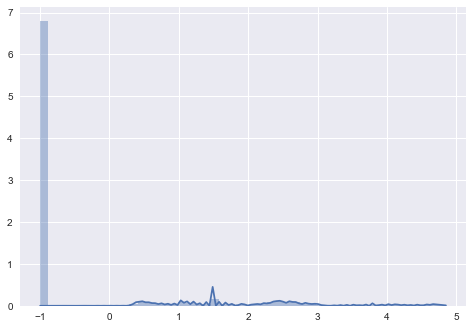

In [143]:
perm_sand_kmap.max()
import seaborn as sns

sns.distplot(perm_shale_kmap.flatten())
plt.show()

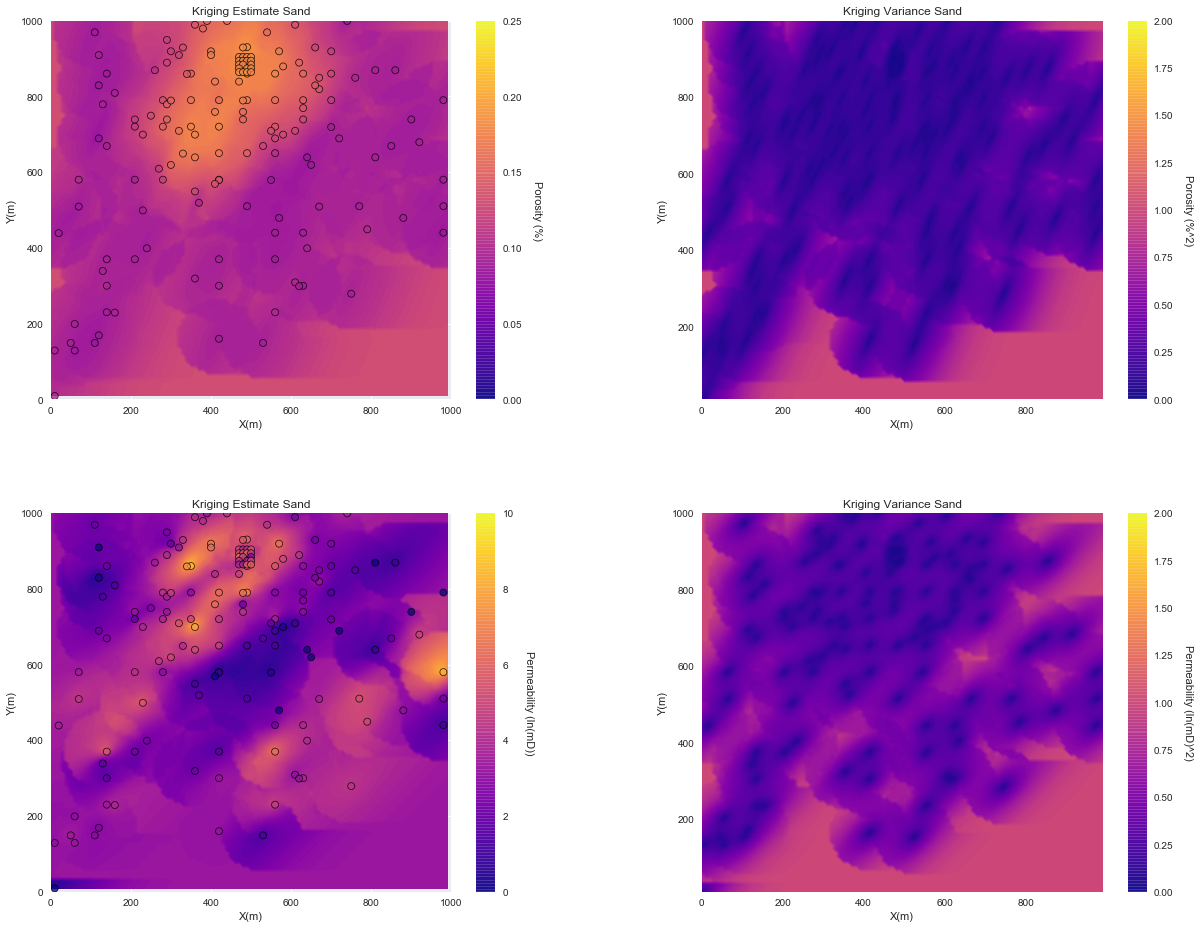

In [114]:
plt.subplot(221)
GSLIB.locpix_st(por_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_sand,'X','Y','Porosity',
                'Kriging Estimate Sand','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(por_sand_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,2
                ,'Kriging Variance Sand','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_sand_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,10,df_sand,'X','Y','lnPerm',
                'Kriging Estimate Sand','X(m)','Y(m)','Permeability (ln(mD))',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(perm_sand_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,2,
                  'Kriging Variance Sand','X(m)','Y(m)','Permeability (ln(mD)^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

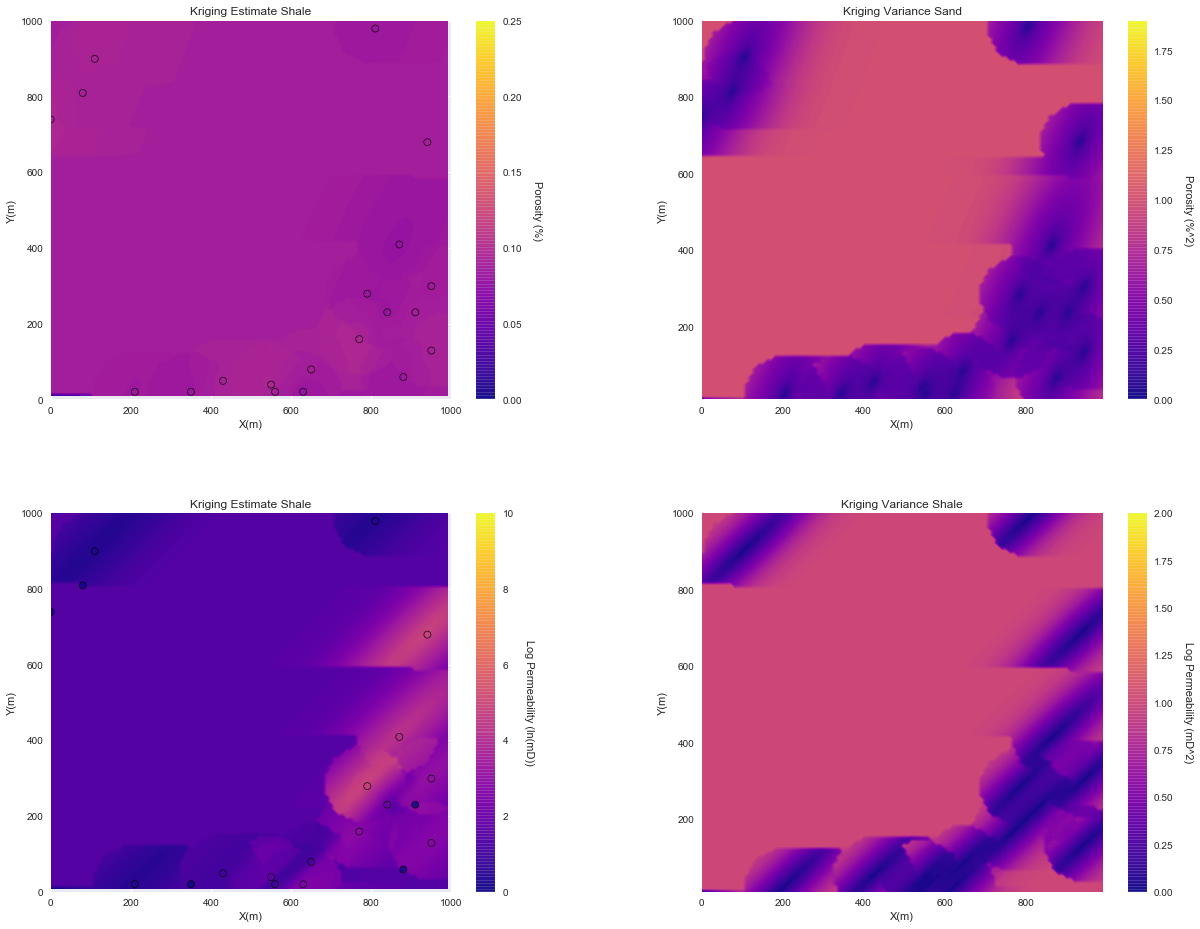

In [115]:
plt.subplot(221)
GSLIB.locpix_st(por_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_shale,'X','Y','Porosity','Kriging Estimate Shale','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.pixelplt_st(por_shale_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.9,'Kriging Variance Sand','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplot(223)
GSLIB.locpix_st(perm_shale_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,10,df_shale,'X','Y','lnPerm','Kriging Estimate Shale','X(m)','Y(m)','Log Permeability (ln(mD))',cmap)

plt.subplot(224)
GSLIB.pixelplt_st(perm_shale_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,2,'Kriging Variance Shale','X(m)','Y(m)','Log Permeability (mD^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.3, hspace=0.3)
plt.show()

# 3. Combined Model with Porosity and Permeability (cookie-cutter approach)


In [172]:
for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            facies_kmap[iy,ix] = 1
            por_kmap[iy,ix] = por_sand_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_sand_kmap[iy,ix];
            por_shale_kmap[iy,ix] = -1
            perm_shale_kmap[iy,ix] = -1
        else:                      # current location is assumed to be shale
            facies_kmap[iy,ix] = 0
            por_kmap[iy,ix] = por_shale_kmap[iy,ix];
            perm_kmap[iy,ix] = perm_shale_kmap[iy,ix];
            por_sand_kmap[iy,ix] = -1
            perm_sand_kmap[iy,ix] = -1

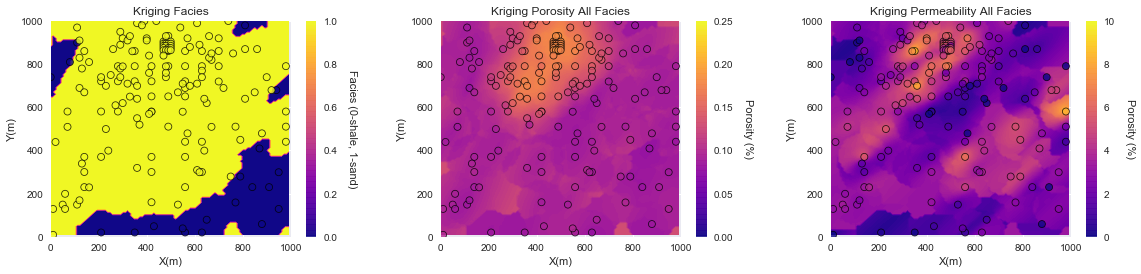

In [147]:
plt.figure(figsize=(5,2.5))
plt.subplot(131)
GSLIB.locpix_st(facies_kmap,xmin,xmax,ymin,ymax,xsiz,0,1,df,'X','Y','Facies','Kriging Facies','X(m)','Y(m)','Facies (0-shale, 1-sand)',cmap)

plt.subplot(132)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Porosity All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(133)
GSLIB.locpix_st(perm_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,10,df,'X','Y','lnPerm','Kriging Permeability All Facies','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

# 4. Report Local P10 and P90 Map for Porosity and Permeability 

In [173]:
from scipy.stats import norm
import math
# f = norm.ppf(0.9)
# print(f)

skmean_por_sand = 0.13; skmean_por_shale = 0.09
skmean_perm_sand = 180.2; skmean_perm_shale = 21.4
skstd_por_sand = 0.034889; skstd_por_shale = 0.00620
skstd_lnperm_sand = 2.1127; skstd_lnperm_shale = 1.8355

map_p10_poro = np.zeros((100,100))
map_p90_poro = np.zeros((100,100))
map_p10_lnperm = np.zeros((100,100))
map_p90_lnperm = np.zeros((100,100))

for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            map_p10_poro[iy,ix] = norm.ppf(.1) * math.sqrt(por_sand_vmap[iy,ix]) * skstd_por_sand + skmean_por_sand
            map_p90_poro[iy,ix] = norm.ppf(.9) * math.sqrt(por_sand_vmap[iy,ix]) * skstd_por_sand + skmean_por_sand
            
            map_p10_lnperm[iy,ix] = norm.ppf(.1) * math.sqrt(perm_sand_vmap[iy,ix]) * skstd_lnperm_sand + skmean_lnperm_sand
            map_p90_lnperm[iy,ix] = norm.ppf(.9) * math.sqrt(perm_sand_vmap[iy,ix]) * skstd_lnperm_sand + skmean_lnperm_sand
        else:                      # current location is assumed to be shale
            map_p10_poro[iy,ix] = norm.ppf(.1) * math.sqrt(por_shale_vmap[iy,ix]) * skstd_por_shale + skmean_por_shale
            map_p90_poro[iy,ix] = norm.ppf(.9) * math.sqrt(por_shale_vmap[iy,ix]) * skstd_por_shale + skmean_por_shale
            
            map_p10_lnperm[iy,ix] = norm.ppf(.1) * math.sqrt(perm_shale_vmap[iy,ix]) * skstd_lnperm_shale + skmean_lnperm_shale
            map_p90_lnperm[iy,ix] = norm.ppf(.9) * math.sqrt(perm_shale_vmap[iy,ix]) * skstd_lnperm_shale + skmean_lnperm_shale

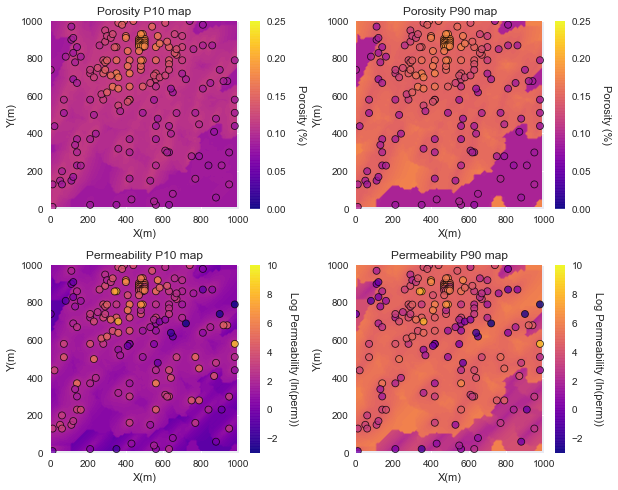

In [151]:
plt.figure(figsize=(2.5,5))
plt.subplot(221)
GSLIB.locpix_st(map_p10_poro,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity',
                'Porosity P10 map','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)
GSLIB.locpix_st(map_p90_poro,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity',
                'Porosity P90 map','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(223)
GSLIB.locpix_st(map_p10_lnperm,xmin,xmax,ymin,ymax,xsiz,-3,10,df,'X','Y','lnPerm',
                'Permeability P10 map','X(m)','Y(m)','Log Permeability (ln(perm))',cmap)

plt.subplot(224)
GSLIB.locpix_st(map_p90_lnperm,xmin,xmax,ymin,ymax,xsiz,-3,10,df,'X','Y','lnPerm',
                'Permeability P90 map','X(m)','Y(m)','Log Permeability (ln(perm))',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.3, hspace=0.3)
plt.show()

# 5. Pick 2 Candidate Well Locations, Provide a Predrill Porosity Uncertainty Distribution (linear family of distribution models) 

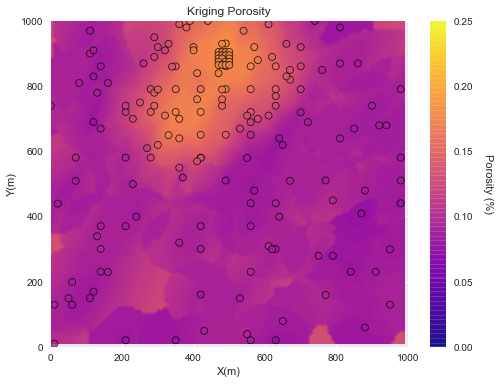

In [193]:
plt.figure(figsize=(8,6))
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df,'X','Y','Porosity','Kriging Porosity','X(m)','Y(m)','Porosity (%)',cmap)
plt.show()

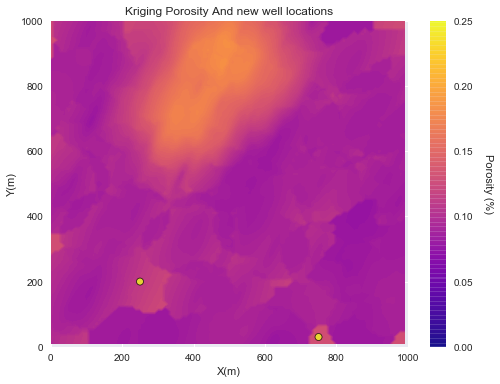

In [199]:
plt.figure(figsize=(8,6))
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,0.0,0.25,df_well_location,'X','Y','Null','Kriging Porosity And new well locations','X(m)','Y(m)','Porosity (%)',cmap)
plt.show()

In [197]:
import pandas as pd 
data = [['Well_1', 250, 200, 100], ['Well_1', 750, 30, 100]]
df_well_location = pd.DataFrame(data, columns = ['Name', 'X', 'Y', 'Null']) 

In [225]:
# well location is map
loc_1 = [24, 79]
loc_2 = [74, 96]

array([[ 1.        ,  1.        ,  1.        ,  0.66395668,  0.60759497,
         0.4437362 ,  0.3856934 ,  0.32773645,  0.27295438,  0.23433334,
         0.197908  ,  0.13890132,  0.11969071,  0.14462091,  0.15607127,
         0.18050326,  0.20195285,  0.21383074,  0.21803303,  0.2207413 ,
         0.16736375,  0.08734993,  0.12350632,  0.15018873,  0.11158931,
         0.05648934,  0.11268813,  0.11163242,  0.09443487,  0.07351733,
         0.13329688,  0.16831696,  0.15177603,  0.11569765,  0.13119193,
         0.14494008,  0.14088257,  0.16008728,  0.15256463,  0.13973287,
         0.0647457 ,  0.09936984,  0.13870694,  0.12992857,  0.15527638,
         0.1589524 ,  0.12628884,  0.06310243,  0.06425586,  0.1406059 ,
         0.1965746 ,  0.21626381,  0.20914638,  0.17794911,  0.14109263,
         0.14311534,  0.14327277,  0.14148279,  0.16338668,  0.16391371,
         0.1447405 ,  0.11072951,  0.06373864,  0.07148826,  0.12816857,
         0.174842  ,  0.19095558,  0.17515524,  0.1

In [221]:
prabaility_bins = np.array(range(1,100,1))/100
CDF_porosity_well_1 = np.zeros(prabaility_bins.size)
CDF_logperm_well_1  = np.zeros(prabaility_bins.size)
CDF_porosity_well_2 = np.zeros(prabaility_bins.size)
CDF_logperm_well_2  = np.zeros(prabaility_bins.size)

In [220]:
prabaility_bins

99

In [ ]:
for ip in range(1,100):
    prob_shale_well_1 = ikmap[loc_1[1],loc_1[0],0]
    prob_sand_well_1 = 1 - prob_shale_well_1
    prob_shale_well_2 = ikmap[loc_2[1],loc_2[0],0]
    prob_sand_well_2 = 1 - prob_shale_well_2
    
    CDF_porosity_well_1(ip)= prob_shale_well_1*(  math.sqrt(por_sand_vmap[iy,ix]) * skstd_por_sand * norm.ppf(prabaility_bins(ip))
    

In [ ]:
for iy in range(0,ny):
    for ix in range(0,nx):
        if ikmap[iy,ix,1] > 0.5:   # current location is assumed to be sand
            map_p10_poro[iy,ix] = norm.ppf(.1) * math.sqrt(por_sand_vmap[iy,ix]) * skstd_por_sand + skmean_por_sand
            map_p90_poro[iy,ix] = norm.ppf(.9) * math.sqrt(por_sand_vmap[iy,ix]) * skstd_por_sand + skmean_por_sand
            
            map_p10_lnperm[iy,ix] = norm.ppf(.1) * math.sqrt(perm_sand_vmap[iy,ix]) * skstd_lnperm_sand + skmean_lnperm_sand
            map_p90_lnperm[iy,ix] = norm.ppf(.9) * math.sqrt(perm_sand_vmap[iy,ix]) * skstd_lnperm_sand + skmean_lnperm_sand
        else:                      # current location is assumed to be shale
            map_p10_poro[iy,ix] = norm.ppf(.1) * math.sqrt(por_shale_vmap[iy,ix]) * skstd_por_shale + skmean_por_shale
            map_p90_poro[iy,ix] = norm.ppf(.9) * math.sqrt(por_shale_vmap[iy,ix]) * skstd_por_shale + skmean_por_shale
            
            map_p10_lnperm[iy,ix] = norm.ppf(.1) * math.sqrt(perm_shale_vmap[iy,ix]) * skstd_lnperm_shale + skmean_lnperm_shale
            map_p90_lnperm[iy,ix] = norm.ppf(.9) * math.sqrt(perm_shale_vmap[iy,ix]) * skstd_lnperm_shale + skmean_lnperm_shale